# Toy Problems from the Book of Why

We'll pull out some of the toy problems in the Book of Why to explore the limitations of DoWhy.  This should give us the clearest idea of why we would like to add to DoWhy.

Features that work well:

* The API works well even when you bring your own data and graph. 

Features that I will need to add or change:

* Daft integration.  Would be great to be able to provide a daft specification to DoWhy instead of their other options. From what I can tell, it seems possible to iterate through notes and edges sufficiently to atleast directly build the networkx object from the Daft object.

* Backdoor Adjustment Algorithm: It seems like the built in algorithm fails to restrict the estimand to those nodes required for the backdoor adjustment.  Further testing will be done to confirm that there are errors. 

## Example 1: Slippery Sidewalks

This is a classic problem that we'll start with. It's fairly self-explanatory from the causal graph, which we shall provide in Daft below.  

In [1]:
import pandas as pd
import numpy as np
import daft
import dowhy
from dowhy.do_why import CausalModel

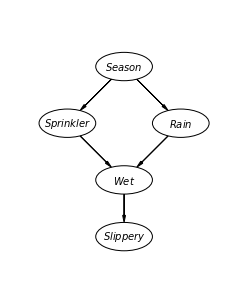

In [2]:
pgm = daft.PGM([4, 5], origin=[0, 0], aspect=2)

pgm.add_node(daft.Node("X5", r"$Slippery$", 2, 1))
pgm.add_node(daft.Node("X4", r"$Wet$", 2, 2))
pgm.add_node(daft.Node("X3", r"$Sprinkler$", 1, 3))
pgm.add_node(daft.Node("X2", r"$Rain$", 3, 3))
pgm.add_node(daft.Node("X1", r"$Season$", 2, 4))

pgm.add_edge("X1", "X2")
pgm.add_edge("X1", "X3")
pgm.add_edge("X2", "X4")
pgm.add_edge("X3", "X4")
pgm.add_edge("X4", "X5")

pgm.render()

In [3]:
# DoWhy isn't compitable with Daft for graph specification... Which isn't great.
# GML graph specification
# For some reason this one is recommended.... But it's sooo much longer.
graph_gml = """graph[directed 1 node[id "Season" label "Season"]
                    node[id "Rain" label "Rain"]
                    node[id "Sprinkler" label "Sprinkler"]
                    node[id "Wet" label "Wet"]
                    node[id "Slippery" label "Slippery"]
                    edge[source "Season" target "Rain"]
                    edge[source "Season" target "Sprinkler"]
                    edge[source "Rain" target "Wet"]
                    edge[source "Sprinkler" target "Wet"]
                    edge[source "Wet" target "Slippery"]]"""

# Equivalent DOT graph
graph_dot = "digraph {Season -> Rain;Season -> Sprinkler;Rain -> Wet;Sprinkler -> Wet;Wet -> Slippery;}"

In [4]:
# We'll make use of sigmoid to use linear models to model binary outcomes
def sigmoid(arr):
    return 1. / (1 + np.exp(-arr))

# Generate some reasonable fake data
nrows = 1000
data = pd.DataFrame({'Season': np.random.choice(2, nrows)})
data['Rain'] = round(sigmoid(0.3 * data.Season - 0.25 + np.random.normal(scale=0.1, size=nrows)))
data['Sprinkler'] = round(sigmoid(0.2 * data.Season - 0.25 + np.random.normal(scale=0.1, size=nrows)))
data['Wet'] = round(sigmoid((0.25 * data.Rain) + (0.25 * data.Sprinkler) - 0.25 + np.random.normal(scale=0.1, size=nrows)))
data['Slippery'] = round(sigmoid(0.5 * data.Wet - 0.25 + np.random.normal(scale=0.1, size=nrows)))

In [5]:
data.describe()

,Season,Rain,Sprinkler,Wet,Slippery
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,0.351000,0.166000,0.263000,0.269000
std,0.50025,0.477522,0.372267,0.440483,0.443662
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.50000,0.000000,0.000000,0.000000,0.000000
75%,1.00000,1.000000,0.000000,1.000000,1.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000


In [6]:
model = CausalModel(
            data=data,
            treatment='Wet',
            outcome='Slippery',
            graph=graph_gml)

['Season', 'Rain', 'Sprinkler']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment Wet on outcome Slippery


Using Matplotlib for plotting


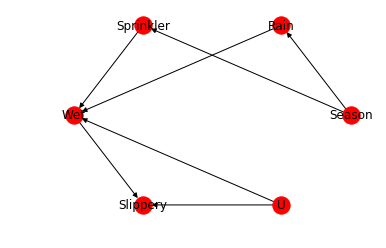

In [9]:
# Their graph visualizer isn't great without graphviz
model.view_model()

In [12]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'Season', 'Rain', 'Sprinkler', 'U'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Rain', 'Sprinkler']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                               
────(Expectation(Slippery|Season,Rain,Sprinkler))
dWet                                             
Estimand assumption 1, Unconfoundedness: If U→Wet and U→Slippery then P(Slippery|Wet,Season,Rain,Sprinkler,U) = P(Slippery|Wet,Season,Rain,Sprinkler)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Slippery, Rain)/Derivative(Wet, Rain))
Estimand assumption 1, As-if-random: If U→→Slippery then ¬(U →→Rain,Sprinkler)
Estimand assumption 2, Exclusion: If we remove {Rain,Sprinkler}→Wet, then ¬(Rain,Sprinkler→Slippery)



In [24]:
lr_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Slippery~Wet+Season+Rain+Sprinkler


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                               
────(Expectation(Slippery|Season,Rain,Sprinkler))
dWet                                             
Estimand assumption 1, Unconfoundedness: If U→Wet and U→Slippery then P(Slippery|Wet,Season,Rain,Sprinkler,U) = P(Slippery|Wet,Season,Rain,Sprinkler)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Slippery, Rain)/Derivative(Wet, Rain))
Estimand assumption 1, As-if-random: If U→→Slippery then ¬(U →→Rain,Sprinkler)
Estimand assumption 2, Exclusion: If we remove {Rain,Sprinkler}→Wet, then ¬(Rain,Sprinkler→Slippery)

## Realized estimand
b: Slippery~Wet+Season+Rain+Sprinkler
## Estimate
Value: 0.992489520260829

## Statistical Significance
p-value: 1.0

Causal Estimate is 0.992489520260829


In [25]:
psm_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        test_significance=True)
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Slippery~Wet+Season+Rain+Sprinkler


PropensityScoreStratificationEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                               
────(Expectation(Slippery|Season,Rain,Sprinkler))
dWet                                             
Estimand assumption 1, Unconfoundedness: If U→Wet and U→Slippery then P(Slippery|Wet,Season,Rain,Sprinkler,U) = P(Slippery|Wet,Season,Rain,Sprinkler)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Slippery, Rain)/Derivative(Wet, Rain))
Estimand assumption 1, As-if-random: If U→→Slippery then ¬(U →→Rain,Sprinkler)
Estimand assumption 2, Exclusion: If we remove {Rain,Sprinkler}→Wet, then ¬(Rain,Sprinkler→Slippery)

## Realized estimand
b: Slippery~Wet+Season+Rain+Sprinkler
## Estimate
Value: 0.992489520260829

## Statistical Significance
p-value: 1.0

Causal Estimate is 0.992489520260829


Observation.  DoWhy has realized the estimand $Slippery \sim Wet + Season + Rain + Sprinkler$.  I really wonder if this is necessary though.  Per our graph, there are no backdoor paths from Wet to Slippery.  Therefore, as long as our graph is correct (particularly with regards to U), then I see no reason to include season, rain, or sprinkler in the regression. We should literally be able to create a simple linear regression from Wet to Slippery. 

In [56]:
import statsmodels.api as sm

lm = sm.OLS(endog=data.Slippery, exog=data.Wet)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Slippery   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                 2.146e+04
Date:                Wed, 13 Mar 2019   Prob (F-statistic):               0.00
Time:                        16:42:21   Log-Likelihood:                 793.91
No. Observations:                1000   AIC:                            -1586.
Df Residuals:                     999   BIC:                            -1581.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Wet            0.9886      0.007    146.490      0.0

The refutations have little effect on the estimated causal effect, but then the causal effect isn't really confounded.

In [34]:
res_random=model.refute_estimate(identified_estimand, lr_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Slippery~Wet+Season+Rain+Sprinkler+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.9794942071876567,)
New effect:(0.9794145760783853,)



In [35]:
res_placebo=model.refute_estimate(identified_estimand, lr_estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Slippery~placebo+Season+Rain+Sprinkler


Refute: Add a Random Common Cause
Estimated effect:(0.9794942071876567,)
New effect:(0.9794145760783853,)



In [36]:
res_subset=model.refute_estimate(identified_estimand, lr_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Slippery~Wet+Season+Rain+Sprinkler


Refute: Use a subset of data
Estimated effect:(0.9794942071876567,)
New effect:(0.9779731627874463,)



Seeing the interesting choices DoWhy made for Wet, I wanted to test a slight modification.  What about the effect of sprinkler on slippery?  In this case there will be backdoor path: $Sprinkler \leftarrow Season \rightarrow Rain \rightarrow Wet \rightarrow Slippery$, which we'll hope that DoWhy will appropriatly identify.

In [40]:
newmodel = CausalModel(
            data=data,
            treatment='Sprinkler',
            outcome='Slippery',
            graph=graph_gml)

['Season']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment Sprinkler on outcome Slippery


In [41]:
identified_estimand = newmodel.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'Season', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                   
──────────(Expectation(Slippery|Season))
dSprinkler                              
Estimand assumption 1, Unconfoundedness: If U→Sprinkler and U→Slippery then P(Slippery|Sprinkler,Season,U) = P(Slippery|Sprinkler,Season)
### Estimand : 2
Estimand name: iv
No such variable found!



In [42]:
lr_estimate = newmodel.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(lr_estimate)
print("Causal Estimate is " + str(lr_estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Slippery~Sprinkler+Season


LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                   
──────────(Expectation(Slippery|Season))
dSprinkler                              
Estimand assumption 1, Unconfoundedness: If U→Sprinkler and U→Slippery then P(Slippery|Sprinkler,Season,U) = P(Slippery|Sprinkler,Season)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Slippery~Sprinkler+Season
## Estimate
Value: 0.3944028924887448

## Statistical Significance
p-value: <0.001

Causal Estimate is 0.3944028924887448


In [55]:
# We can confirm this estimate against what we could produce without DoWhy
lm = sm.OLS(endog=data['Slippery'], exog=data[['Season', 'Sprinkler']])
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               Slippery   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     645.9
Date:                Wed, 13 Mar 2019   Prob (F-statistic):          1.05e-180
Time:                        16:41:59   Log-Likelihood:                -347.17
No. Observations:                1000   AIC:                             698.3
Df Residuals:                     998   BIC:                             708.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Season         0.3893      0.019     20.940      0.0